# PIRIS + Bayesian Optimization
**Bayesian Optimization for hyperparameter tunning in PIRIS**


# Librerias

In [1]:
#Needed install for optuna plots saving
!pip install --target=/kaggle/working kaleido==0.2.1 -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 21.5 MB/s eta 0:00:00


In [2]:
# In case i need to clear the workspace
#!rm -rf /kaggle/working/*

In [3]:
#Importamos las librerias necesarias
#Basicas para manejo de números, arreglos, y plots
import numpy as np
import json
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns


#Especificas de ML
import tensorflow as tf #General para la optimizacion por gradiente
from sklearn.cluster import kmeans_plusplus #Necesaria para proponer puntos iniciales
import optuna # Optimizacion de hiperparametros
from optuna.samplers import GPSampler
from optuna.visualization import (
    plot_param_importances,
    plot_contour
)

# Medicion de tiempo y estetica
import time #para medir tiempo de computo
from tqdm.notebook import tqdm # Para barras de progreso

optuna.logging.set_verbosity(optuna.logging.CRITICAL) #Evita prints fuertes de optuna

2025-08-19 20:32:11.212173: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755635531.432933      18 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755635531.498420      18 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# kmeans++

**Para el k-means++, necesitamos unos limites alrededor de la superficie**

In [4]:
def calcular_limites_superficie(posiciones, geometria, params, param_tensors, padding=2.0):
    """
    Calcula los límites en (x,y) de una estructura atómica plana, añadiendo un margen.
    O el centro si es una estrutura no plana.

    Args:
        posiciones (np.ndarray): Un array de forma (N, 3) con las coordenadas (x,y,z)
                                 de los átomos de la superficie.
        padding (float): Un margen en Angstroms que se añadirá en cada dirección
                         (min y max) a los límites de la estructura.

    Returns:
        info_k_means:
        Un diccionario conteniendo la informacion para la selección de candidatos. 
               Formato: {
                   tipo: (plano o 3D),
                   limite: tupla de limites en xy ((x_min,x_max),(y_min,y_max)) o centro de la muestra (x_center,y_center,z_center)
                   escala_caracteristica: factor base para la optimizacion de optuna (np.float)
               }
    """
    if posiciones.ndim != 2 or posiciones.shape[1] < 2:
        raise ValueError("El array de posiciones debe tener forma (N, 2) o (N, 3).")

    ion_type = params['ion_type']
    ion_index = param_tensors['type_map'].lookup(tf.constant([ion_type]))[0]
        
    if geometria=="planar":
        # Extraer las coordenadas x e y
        x_coords = posiciones[:, 0]
        y_coords = posiciones[:, 1]
        
        # Encontrar los valores mínimos y máximos
        x_min, x_max = np.min(x_coords), np.max(x_coords)
        y_min, y_max = np.min(y_coords), np.max(y_coords)
        
        # Aplicar el padding
        limites_x = (x_min - padding, x_max + padding)
        limites_y = (y_min - padding, y_max + padding)

        # Definir la escala para que optuna optimice en factores de esta escala
        # En este caso la escala esta relacionada directamente con el radio de van der walls para la interaccion de mayor potencial
        max_epsilon = 0.0
        escala_caracteristica = 0.0
        surface_atom_types = [t for t in params['atom_types'] if t != ion_type]
        
        for atom_type in surface_atom_types:
            surface_index = param_tensors['type_map'].lookup(tf.constant(atom_type))
            
            epsilon = param_tensors['epsilon_matrix'][ion_index][surface_index].numpy()
            if epsilon > max_epsilon:
                max_epsilon = epsilon
                escala_caracteristica = param_tensors['sigma_matrix'][ion_index][surface_index].numpy()
        
        if escala_caracteristica == 0.0: # Fallback if no surface atoms
            escala_caracteristica = param_tensors['sigma_matrix'][ion_index][ion_index].numpy()
        
        
        print(f"Límites de la estructura calculados:")
        print(f"  - Rango X (con padding): ({limites_x[0]:.2f}, {limites_x[1]:.2f})")
        print(f"  - Rango Y (con padding): ({limites_y[0]:.2f}, {limites_y[1]:.2f})")
        info_k_means = {
            "tipo": "planar",
            "limite": (limites_x, limites_y),
            "escala": escala_caracteristica
        }
        return info_k_means
        
    elif geometria=="3D":
        centro = np.mean(posiciones, axis=0)
        
        #Para el modelo 3D, la escala estará dada por la distancia al centro de la nanoparticula
        distancias_al_centro = np.linalg.norm(posiciones_atomos - centro, axis=1)
        escala_caracteristica = np.max(distancias_al_centro)
        info_k_means = {
            "tipo":"3D",
            "limite": centro,
            "escala": escala_caracteristica
        }
        return info_k_means
    else:
        raise ValueError(f"Tipo de geometría '{geometria}' no soportado.")

**Con los limites ya calculados, generamos las posibles opciones de posicion inicial**

In [5]:
def starting_point_suggestions(info_k_means, puntos_por_eje):
    """
    Generalos candidatos para que k-means++ elija posiciones iniciales 
    Args:
        geometria: informacion para la eleccion de candidatos (dict)
        puntos_por_eje (int): Número de puntos a generar por cada eje.

    Returns:
        options:
        para geometria planar: malla de posibles puntos (x,y)
        para geometria 3D: vectores de direccion en una esfera unitaria
    """

    #Extraemos el tipo de geometria
    tipo = info_k_means["tipo"]
    if tipo == "planar":
        limites_x, limites_y = info_k_means["limite"]
        # Generar los puntos en cada eje usando los límites calculados
        x_coords = np.linspace(limites_x[0], limites_x[1], puntos_por_eje)
        y_coords = np.linspace(limites_y[0], limites_y[1], puntos_por_eje)
        
        # Crear la malla usando meshgrid
        xx, yy = np.meshgrid(x_coords, y_coords)
        
        # Aplanar y combinar en un array de coordenadas (N, 2)
        options = np.vstack([xx.ravel(), yy.ravel()]).T
        
        print(f"Malla de {options.shape[0]} posiciones candidatas creada sobre los límites definidos.")
        return options
    elif tipo == "3D":
        # Generar vectores aleatorios y normalizarlos para obtener puntos en una esfera unitaria
        options = np.random.randn(puntos_por_eje, 3)
        options /= np.linalg.norm(options, axis=1, keepdims=True)
        print(f"Malla de {options.shape[0]} posiciones candidatas creada sobre los límites definidos.")
        return options # Estos son nuestros vectores de dirección candidatos
    else:
        raise ValueError("Forma de configuración no reconocida.")

**Teniendo las opciones, solo falta elegir**

In [6]:
def generate_xy(options, k_simulaciones, num_ni_por_simulacion, random_seed=42):
    """
    Selecciona 'k_simulaciones' conjuntos de 'num_ni_por_simulacion' posiciones iniciales
    cada uno.

    Args:
        options(np.ndarray): Array de posiciones candidatas (N, 2) si es geometria planar, o  vectores unitarios(N,3) si es
        un estructura 3D.
        k_simulaciones (int): Número de simulaciones/configuraciones a generar.
        num_ni_por_simulacion (int): Número de iones en cada simulación.
        random_seed (int): Semilla para reproducibilidad.

    Returns:
        list: Una lista de 'k_simulaciones' arrays. Cada array tiene forma 
              (num_ni_por_simulacion, 2) si es geometria plana, o (num_ni_por_simulacion,3) si es 
              3D, y representa una configuración inicial.
    """
    
    total_puntos = k_simulaciones * num_ni_por_simulacion
    puntos_seleccionados, _ = kmeans_plusplus(options, n_clusters=total_puntos, random_state=random_seed)
    configuracion = np.array_split(puntos_seleccionados, k_simulaciones)
    return configuracion


# Creación de los iones que se van a adsorber

**La optimizacion de hiperparametros contemplara la distancia de los iones a la muestra como un hiperparametro** 

In [7]:
def build_ions(configuracion, factor_opt, info_k_means):
    """Recibe posiciones iniciales pre definidas y la distancia para combinarlas y generar los iones
    a adsorber
    args: 
        configuracion:array con un conjunto de posiciones iniciales preseleccionadas.
        factor_opt: factor de distancia que  optimiza optuna (float)
        info_k_means: informacion respecto a las opciones de la muestra (dict)
    returns:
        np.ndarray: Array de forma (num_ni, 3) con las posiciones completas (x,y,z) de los iones"""

    # Primero sacamos de la info, el valor de la escala
    escala = info_k_means["escala"]
    #convertimos esa escala en una distancia usando el factor de optuna
    distancia = escala * factor_opt
    
    if info_k_means["tipo"] == "planar":
        #Tomamos la cantidad de iones del array de coordenaads xy
        num_ni = configuracion.shape[0]
        # Crea una columna de 'z' con el mismo valor para todos los iones
        z_column = np.full((num_ni, 1), distancia) #Aqui la distancia actua como altura o lejania directa a la superficie plana
        
        # Concatena las posiciones (x,y) con la columna z
        ion_positions = np.hstack([configuracion, z_column])
        
        return ion_positions
    elif info_k_means["tipo"] == "3D":
        centro = info_k_means["limite"]
        ion_positions = centro + distancia * configuracion #Aqui la distancia actua como un radio directo al centro de la nanoparticula
        return ion_positions
    
    else:
        raise ValueError("Forma de configuración no reconocida.")

# Definición del costo para entrenamiento y evaluación.

**Costo de entrenamiento**

In [8]:
# Lennard-Jones potential function
@tf.function
def physical_potential(r, epsilon, sigma, q_i, q_j, k_e):
    sr6 = tf.math.pow(sigma / r, 6)
    sr12 = tf.math.pow(sr6, 2)
    lj = 4.0 * epsilon * (sr12 - sr6) + epsilon #for stability
    coulomb = k_e * q_i * q_j / tf.maximum(r, 1e-10)
    return lj + coulomb

# Funcion para calcular el potencial de informacion, individual y cruzado
@tf.function
def calculate_cross_information_potential(points1, points2, sigma):
    """
    Calcula el Potencial de Información Cruzado (V) entre dos conjuntos de puntos.
    Si points1 y points2 son el mismo, calcula el Potencial de Información (IP).
    """
    diff = tf.expand_dims(points1, 1) - tf.expand_dims(points2, 0)
    sq_dists = tf.reduce_sum(tf.square(diff), axis=-1)
    kernel_matrix = tf.exp(-sq_dists / (2.0 * sigma**2))
    return tf.reduce_mean(kernel_matrix)
    
# Función de costo para el entrenamiento del modelo
@tf.function
def get_training_loss(positions, elements, ion_positions, pri_weight, lambda_pri, sigma_pri, ion_type, param_tensors):
     """
    Calcula la energía total de las interacciones entre los iones (ni_positions) y la superficie (positions),
    utilizando un potencial fisico y una regularizacion por PRI.
    Parameters:
        Ni_positions: tensor con posiciones de los iones (num_iones, 3)
        Positions: tensor con posiciones de los átomos de la superficie (num_atoms, 3)
        Elements: tensor con etiquetas de tipo de atomo (num_superficie,)
        pri_weight,lambda_pri,sgma_pri: hiperparametros escalares que modelan el peso de la regularización
        ion_type: Indicador de la especie que se va a adsorber (str)
        param_tensors: diccionario de parametros para la simulacion
    Returns:
        Energía total del sistema (escalar)
        Energía total de cada ion (num_iones,)
    """

    # --- Saber los indices para cada tipo de atomo ---
     surface_indices = param_tensors['type_map'].lookup(elements) # e.g., [0, 1, 0, 1, ...]
     ion_index = param_tensors['type_map'].lookup(tf.constant([ion_type]))[0] # e.g., 2
    
    #----------------------INTERACCIONES ION-NANOESTRUCTURA-------
    # Expandir dimensiones para obtener todas las combinaciones de distancias ion-atomo
     pos_exp = tf.expand_dims(positions, axis=1)  # (num_atoms, 1, 3)
     ion_exp = tf.expand_dims(ion_positions, axis=0)  # (1, num_iones, 3)
   
     r = tf.norm(pos_exp - ion_exp, axis=2)  # Uso la norma para calcular la magnitud de la distancia 
                                # entre cada ion y cada átomo de la superficie (num_iones, num_atoms)

     # --- Recoleccion de parametros ---
     # Traemos cada parametro de interaccion cruzada Ni-cualquier atomo
     sigmas = tf.gather(param_tensors['sigma_matrix'][ion_index], surface_indices)
     epsilons = tf.gather(param_tensors['epsilon_matrix'][ion_index], surface_indices)
     cutoffs = tf.gather(param_tensors['cutoff_matrix'][ion_index], surface_indices)

    # Traemos las cargas para los atmos de la superficie y los iones
     q_surface = tf.gather(param_tensors['q'], surface_indices)
     q_ion = param_tensors['q'][ion_index]

    # Calculamos las energias que estan asociadas a los tensoresde sigmas, epsilons, y cargas, dentro de las ditancias de corte
     atoms_energy_matrix = tf.where(r < cutoffs,
                             physical_potential(r, epsilons, sigmas, q_ion, q_surface, param_tensors['k_e']),
                             tf.zeros_like(r))

    # Energía total por ion (sumando sobre átomos)
     energy_per_ion = tf.reduce_sum(atoms_energy_matrix, axis=0)  # shape: (num_ions,)


    #----------------------INTERACCIONES ION-ION-------
    # Calcula matriz de vectores diferencia entre iones
     diff_ion = tf.expand_dims(ion_positions, 0) - tf.expand_dims(ion_positions, 1)  # (num_ions, num_ions, 3)
    # Calcula matriz de distancias usando norma
     r_ion = tf.norm(diff_ion, axis=-1)  # (num_ions, num_ions)

    # Construye máscaras para excluir la diagonal y aplicar cutoff
     eye = tf.eye(tf.shape(ion_positions)[0], dtype=tf.bool)  # diagonal True
     mask_offdiag = tf.logical_not(eye)  # off-diagonal True


    # Traemos los parametros de interaccion ion_ion
     sigma_ion_ion = param_tensors['sigma_matrix'][ion_index, ion_index]
     epsilon_ion_ion = param_tensors['epsilon_matrix'][ion_index, ion_index]
     cutoff_ion_ion = param_tensors['cutoff_matrix'][ion_index, ion_index]


     mask_cutoff = tf.less(r_ion, cutoff_ion_ion)  # True si r < cutoff
     interaction_mask_ions = tf.logical_and(mask_offdiag, mask_cutoff)  # pares válidos distintos
    # Prepara distancias válidas evitando divisiones por cero
     valid_r = tf.where(interaction_mask_ions, tf.maximum(r_ion, 1e-10), tf.ones_like(r_ion))

    # Calcula energía Lennard-Jones solo en pares válidos
     ion_energy_matrix = tf.where(interaction_mask_ions,
                                 physical_potential(valid_r, epsilon_ion_ion, sigma_ion_ion, q_ion, q_ion, param_tensors['k_e']),
                                 tf.zeros_like(r_ion))
    # Energías totales ion_ion
     ion_ion_energy_per_ion = tf.reduce_sum(ion_energy_matrix, axis=0)  # (num_ions,)
    
    # calcular la energía total del sistema y la energía por ion
     ion_ion_total_energy = tf.reduce_sum(ion_ion_energy_per_ion) * 0.5 #Multiplico por 0.5 porque la energia aparece una vez para cada ion
     energy_total_per_ion = energy_per_ion + ion_ion_energy_per_ion
     energy_total = tf.reduce_sum(energy_per_ion)+ion_ion_total_energy

    #--------------------REGULARIZACIÓN CON PRI----------------------
    # Analogía: positions -> majority class | ion_positions -> undersampled majority class 

     epsilon_log = 1e-10  # Para estabilidad numérica en el logaritmo

    # Calcular potenciales de información
     ip_ions = calculate_cross_information_potential(ion_positions, ion_positions, sigma_pri)
     ip_surface = calculate_cross_information_potential(positions, positions, sigma_pri) # Es constante, pero se calcula aquí por simplicidad
     cip_ions_surface = calculate_cross_information_potential(ion_positions, positions, sigma_pri)
    # Calcular entropías cuadráticas (H2 = -log(V))
     H2_ions = -tf.math.log(ip_ions + epsilon_log)
     H2_surface = -tf.math.log(ip_surface + epsilon_log)
     H2_cross = -tf.math.log(cip_ions_surface + epsilon_log)

    # Calcular Divergencia de Cauchy-Schwarz (D_cs= 2H2(ion,surface)- H2(ion)- H2(surface)) - Eq. 4 del paper
     D_cs = 2 * H2_cross - H2_ions - H2_surface
    # Calcular costo PRI - Eq. 7 del paper
    # J(X_hat) = H2(X_hat) + lambda * D_cs(X_hat, X)
     pri_cost = (1- lambda_pri)*H2_ions + 2*lambda_pri * D_cs

    #------------COMBINAR Y RETORNAR----------------

     total_loss = energy_total + pri_weight * pri_cost
    
     return  total_loss, energy_total_per_ion

**Costo de evaluación**

In [9]:
#@tf.function
def calculate_final_system_energy(positions, elements, ion_positions, ion_type, param_tensors):
    """
    Calcula la energía del sistema sin PRI y corrige el shift potencial de la energía
    """

    # --- Traemos los parametros de cada tipo de atomo ---
    surface_indices = param_tensors['type_map'].lookup(elements)
    ion_index = param_tensors['type_map'].lookup(tf.constant([ion_type]))[0]
    
    pos_exp = tf.expand_dims(positions, axis=1)
    ion_exp = tf.expand_dims(ion_positions, axis=0)
    r = tf.norm(pos_exp - ion_exp, axis=2)

    #----------------------SURFACE-ION Interactions---------------
    
    # --- Sigmas, epsilons  y cortes en tensores ---
    sigmas = tf.gather(param_tensors['sigma_matrix'][ion_index], surface_indices)
    epsilons = tf.gather(param_tensors['epsilon_matrix'][ion_index], surface_indices)
    cutoffs = tf.gather(param_tensors['cutoff_matrix'][ion_index], surface_indices)
    # --- cargas---
    q_surface = tf.gather(param_tensors['q'], surface_indices)
    q_ion = param_tensors['q'][ion_index]

    #calculamos la energia usando los tensores
    atoms_energy_matrix = tf.where(r < cutoffs,physical_potential(r, epsilons, sigmas, q_ion, q_surface, param_tensors['k_e']),
                             tf.zeros_like(r))
    
    energy_per_ion = tf.reduce_sum(atoms_energy_matrix, axis=0)

    #---------------------- ION-ION INTERACTIONS ----------------------
    diff_ion = tf.expand_dims(ion_positions, 0) - tf.expand_dims(ion_positions, 1)
    r_ion = tf.norm(diff_ion, axis=-1)
    eye = tf.eye(tf.shape(ion_positions)[0], dtype=tf.bool)
    mask_offdiag = tf.logical_not(eye)

    # Traemos los parametros de interacciones ion-ion
    sigma_ion_ion = param_tensors['sigma_matrix'][ion_index, ion_index]
    epsilon_ion_ion = param_tensors['epsilon_matrix'][ion_index, ion_index]
    cutoff_ion_ion = param_tensors['cutoff_matrix'][ion_index, ion_index]
    
    mask_cutoff = tf.less(r_ion, cutoff_ion_ion)
    interaction_mask_ions = tf.logical_and(mask_offdiag, mask_cutoff)
    valid_r = tf.where(interaction_mask_ions, tf.maximum(r_ion, 1e-10), tf.ones_like(r_ion))
    
    ion_energy_matrix = tf.where(interaction_mask_ions,
                                 physical_potential(valid_r, epsilon_ion_ion, sigma_ion_ion, q_ion, q_ion, param_tensors['k_e']),
                                 tf.zeros_like(r_ion))
    ion_ion_energy_per_ion = tf.reduce_sum(ion_energy_matrix, axis=0)
    
    ion_ion_total_energy = tf.reduce_sum(ion_ion_energy_per_ion) * 0.5
    physical_energy_total = tf.reduce_sum(energy_per_ion) + ion_ion_total_energy
    
    return physical_energy_total, energy_per_ion + ion_ion_energy_per_ion

**Definmos un exponential decay learning rate**

In [10]:
def exp_decay_lr(initial_lr, decay_rate, epoch):
    return initial_lr * decay_rate ** (epoch/5)

**Definimos clase para early stop**

In [11]:
# Early_stop Callback class
class EarlyStoppingCallback:
    def __init__(self, patience, min_delta):
        self.patience = patience
        self.min_delta = min_delta
        self.wait = 0
        self.best_loss = float('inf')
        self.stopped_epoch = 0

    def on_epoch_end(self, epoch, loss):
        if loss < self.best_loss - self.min_delta:
            self.best_loss = loss
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                return True  # Signal to stop training
        return False  # Continue training

# Bayesian Optimization

**Definimos la funcion objetivo de la optimización bayesiana**

In [12]:
def objective(trial, params, param_tensors):
    """
    Objective function for Optuna to minimize.
    It runs the PIRIS simulation for a given set of hyperparameters.
    """

    # Traemos de los atributos del trial la posicion inicial y la informacion de kmeans
    position_str = trial.study.user_attrs["starting_position"]
    # Convert the JSON string back into a Python list/array
    configuracion = np.array(json.loads(position_str))
    info = trial.study.user_attrs["info"]
    #Traemos los parametros
    params = trial.study.user_attrs["params"]
    #param_tensors = trial.study.user_attrs["param_tensors"]
    ion_type = params['ion_type'] 
    
    # --- 1. Suggest hyperparameters from the trial object ---
    # Factor: aumento de la distancia con respecto a la escala caracteristica de la superficie
    factor_initial = trial.suggest_float("factor", 1.0, 6.0)

    # PRI hyperparameters
    pri_weight_val = trial.suggest_float("pri_weight", 0.0, 10.0) #Up to 10 given the magnitude of H vs PRI loss
    lambda_pri_val = trial.suggest_float("lambda_pri", 0.0, 1.0)


    
    # Sigma_pri: search space follows the magnitude of distance, which in return is given by the factor parameter
    # We have 2 cases, plane or 3D structure, we account for this using the inherent scale as reference
    sigma_pri_val = trial.suggest_float("sigma_pri", 1.0, 6*info["escala"])

    # Use the learning rate and decay rate suggested by the trial
    eta0 = trial.suggest_float("learning_rate", 1e-3, 5e-1, log=True)
    decay_rate = trial.suggest_float("decay_rate", 0.90, 0.99)

    # --- 2. Setup the simulation for this trial ---
    # Create the initial ion positions with the suggested opt_param
    initial_ion_positions = build_ions(configuracion, factor_initial, info)
    ion = tf.Variable(initial_ion_positions, dtype=tf.float32)

    # Cast hyperparameters to TensorFlow constants for this trial
    pri_weight = tf.constant(pri_weight_val, dtype=tf.float32)
    lambda_pri = tf.constant(lambda_pri_val, dtype=tf.float32)
    sigma_pri = tf.constant(sigma_pri_val, dtype=tf.float32)

    # --- 3. Run the training loop ---
    epochs = 100  # Reduced for faster optimization trials
    optimizer = tf.keras.optimizers.Adam(learning_rate=eta0)

    for epoch in range(epochs):
        eta = exp_decay_lr(eta0, decay_rate=decay_rate, epoch=epoch)
        optimizer.learning_rate.assign(eta)
        
        with tf.GradientTape() as g:
            g.watch(ion)
            H_loss, _ = get_training_loss(sample_atoms, sample_elements, ion.value(), 
                                          pri_weight, lambda_pri, sigma_pri, 
                                          ion_type, param_tensors)
        
        grad_ = g.gradient(H_loss, ion)
        
        # Check for NaN gradients which can happen with extreme hyperparameters
        if tf.reduce_any(tf.math.is_nan(grad_)):
            # If gradients are NaN, the trial is bad. Return a large value.
            return 1e6

        optimizer.apply_gradients(zip([grad_], [ion]))

    # --- 4. Calculate final energy and return it ---
    final_energy, _ = calculate_final_system_energy(sample_atoms, sample_elements, ion.value(),
                                                    ion_type, param_tensors)
    
    return final_energy.numpy()

**Optimization loop**

In [13]:
def optimization(positions, geometria, puntos_por_eje, k, num_ni, num_trials, params, param_tensors, random_seed=42):
    """Funcion para ejecutar el loop de optimizacion
    args: 
        positions: posiciones que componen la superficie del adsorbente (np.array)
        geometria: tipo de muestra (str)
        puntos_por_eje: cantidad de puntos a tomar como muestra desde el kmeans++ en cada eje (int)
        k: número de muestras a elegir por kmeans++ (int)
        num_ni: número de iones a adsorber de forma simultanea (int)
        num_trials: número de pruebas para realizar por cada posicion inicial (int)
        params: parametros especificos del material (dict)
        param_tensors: tensores de los parametros
    Returns:
        Studies: lista con todos los k estudios realizados y sus parametros (list)
        Trials: lista con los mejores trials de cada estudio (list)"""

    #Definimos el box alrededor de la superficie para los candidatos a xy
    info_k_means = calcular_limites_superficie(positions,geometria, params=params, param_tensors=param_tensors, padding=2.0)
    
    #Definimos la malla de candidatos xy
    malla = starting_point_suggestions(info_k_means, puntos_por_eje)
    
    #Ejecutamos el algoritmo k-means++ para elegir los candidatos
    configuraciones=generate_xy(malla, k, num_ni, random_seed)
    
    Studies = [] #Estudios completos para el plot de importancia
    Trials = [] #Mejor resultado para cada estudio
    
    for i, xy_positions in enumerate(tqdm(configuraciones, desc="Hyperparameter optimization")):
        print("Starting position: ",i)
        print("x,y for try ",i,": ",xy_positions)
        study_name = f'Starting_position_{i}'
        # Creamos el objeto estudio, dando nombre, direccion (minimizar) y usando un GP como sampler.
        study = optuna.create_study(study_name=study_name, direction='minimize', sampler=GPSampler(seed=10))
        
        # Vamos a necesitar algunos valores, así que los guardamos como atributos del estudio
        list_positions = xy_positions.tolist()
        study.set_user_attr("starting_position", json.dumps(list_positions)) #set de posiciones iniciales de los iones
        study.set_user_attr("info", info_k_means) # informacion de las posiciones iniciales
        study.set_user_attr("params", params) #Diccionario de parametros de simulacion
        #Deberiamos enviar tambien los tensores, pero no se pueden pasar como json en user_attr, entonces se pasan con un lambda
        objective_with_params = lambda trial: objective(trial, params, param_tensors)
        study.set_user_attr("param_tensors", param_tensors) # Store it for the final training loop

        # Optimizamos, optuna llama la funcion objetivo n_trials veces
        study.optimize(objective_with_params, n_trials=num_trials)
        
        
        # --- guardamos resultados ---
        Studies.append(study) # el estudio completo
        
        trial = study.best_trial # tomamos el mejor trial
    
        Trials.append(trial) # y lo guardamos por separado
    return Studies, Trials

In [14]:
def optimization_summary(Trials):
    """Toma los datos de la optimizacion y hace un dataframe con los mejores trials
    Args:
        Trials: Lista con los mejores trials por posicion inicial (list)
    Returns:
        data: Informacion de los hiperparametros y resultados de cada Trial (pd.dataframe)"""
    records =[]
    for trial in Trials:
        record={"Energy":trial.value}
        record.update(trial.params)
        records.append(record)
    data = pd.DataFrame(records)
    print("Summary of the best trials:")
    print(data)
    return data

**Visualizacion de los resultados de la optimización**

**Importance plot**

In [15]:
def importance_plot(Studies):
    """Lee los datos de los estudios de optuna y grafica la importancia de cada hiperparametro con su respectiva varianza
    Args: 
        Studies: Lista con todos los datos de cada estudio realizado para cada posicion inicial (List)
    Returns:
        None"""
    # Creamos una lista con las importancias de todos los estudios
    all_importances = [optuna.importance.get_param_importances(s) for s in Studies]
    
    #Lo convertimos a dataframe al ser una lista de diccionarios
    df_importances = pd.DataFrame(all_importances)
    #por si algun parametro se queda fuera, cambiamos NaN a 0
    df_importances = df_importances.fillna(0)
    
    # Calculamos la media y la desviacion estandar de cada parametro a lo largo de las columnasdel df
    mean_importances = df_importances.mean().sort_values(ascending=False)
    std_importances = df_importances.std().loc[mean_importances.index] # aseguramos que mantenga el orden
    
    # Y ploteamos on plt
    plt.figure(figsize=(12, 8))
    bars = plt.barh(
        y = mean_importances.index,
        width = mean_importances,
        xerr=std_importances, # This adds the error bars (std dev)
        capsize=5, # Puts caps on the error bars
        color=sns.color_palette("viridis_r", len(mean_importances))
    )
    
    #Invierte el eje para que el y mas grande esté arriba
    plt.gca().invert_yaxis()
    
    # añadimos titulos y labels
    plt.title('Importancia promedio de los hiperparametros para todas las posiciones iniciales', fontsize=16, fontweight='bold')
    plt.ylabel('Hiperparametros', fontsize=12)
    plt.xlabel('Imporancia media', fontsize=12)
    plt.tight_layout() # Adjust layout to make room for labels
    
    
    # Save the graph
    plot_name = f"Parameter_importance_{sample_name}.pdf"
    plt.savefig(
    f"/kaggle/working/{plot_name}",
    format='pdf',
    bbox_inches='tight', # Removes excess white space
    dpi=300              # Good resolution for printing
    )
    # Show the parameter importances
    plt.show()

**Contour plots**

In [16]:
def contour_plot(Trials,Studies):
    """Lee la informacion de la optimizacion para hacer los diagramas de contorno de los hiperparametros de interes
    Args:
        Trials: Lista con los mejores trials de cada posicion inicial (list)
        Studies: Inforamcion completa de todos los estudios para todas las posiciones iniciales (list)
    Retruns:
        best_study: Datos de la posicion inicial con el mejor rendimiento (optuna.study object)"""
    # Contour plot de los hiperparametros más importantes
    
    # Identifica el mejor trial de todos
    best_overall_trial = min(Trials, key=lambda t: t.value)
    
    # Determinar a que posicion inicial pertenece
    best_study = None
    for study in Studies:
        # We compare the best trial of the current study in the loop
        # with the 'best_overall_trial' we found earlier.
        # FrozenTrial objects can be compared directly for equality.
        if study.best_trial == best_overall_trial:
            best_study = study
            break # We found the matching study, so we can exit the loop
    
    # It's good practice to handle the case where we somehow don't find a match.
    if best_study is None:
        raise RuntimeError("Could not find the parent study for the best trial. This should not happen.")
    
    # crear, mostrar y guardar 2 plots para diferentes parametros
    z_sigma_plot = plot_contour(best_study, params =["factor","sigma_pri"])
    z_sigma_plot.update_layout(
    title="Contour Plot scaling factor vs Sigma",
    )
    z_sigma_plot.show()
    plot_name_sigma = f'z_sigma_plot_{sample_name}.pdf'
    z_sigma_plot.write_image(plot_name_sigma)
    
    pri_physics_plot = plot_contour(best_study, params =["pri_weight","lambda_pri"])
    pri_physics_plot.update_layout(
    title="Contour Plot Pri vs hamiltoninan weight",
    )
    pri_physics_plot.show()
    plot_name = f'pri_physics_plot_{sample_name}.pdf'
    pri_physics_plot.write_image(plot_name)
    
    
    return best_study

**Llamamos toda la visualizacion de resultados en una sola función**

In [17]:
def optimization_results(Studies, Trials):
    """Llama todas las funciones de visualizacion de resultados
    Args:
        Studies: Inforamcion completa de todos los estudios para todas las posiciones iniciales (list)
        Trials: Lista con los mejores trials de cada posicion inicial (list)
    Returns:
        best_study: Datos de la posicion inicial con el mejor rendimiento (optuna.study object)"""
    
    optimization_summary(Trials)
    importance_plot(Studies)
    best_study = contour_plot(Trials,Studies)
    return best_study

# Entrenamiento y resultados

**Loop de entrenamiento con los hiperparametros optimizados**

In [18]:
def training_loop(best_study, epochs,  positions, sample_atoms, sample_elements, params, param_tensors):
    """Realiza todo el loop de entrenamiento cn los hiperparametros optimizados
    Args: 
        best_study: datos de la mejor posicion inicial (optuna.study object)
        epochs: número de epocas para el entrenamiento (int)
        positions: coordenadas de la superficie para las graficas (np.array)
        sample_atoms: coordenadas de la superficie para el entrenamiento (tf.tensor (float32))
        sample_elements: etiquetas del tipo de elemento para el entrenamiento (tf.tensor (str))
    Returns:
        ion_final: posicion inicial definitiva de (los) ion(es), optimizada por optuna (tf.variable (float32))
        ion_final_:posicion final de (los) ion(es), optimizada por el entrenamiento en formato numpy(np.float32)
        starting_pos: posicion inicial definitiva de (los) ion(es), optimizada por optuna en formato numpy (np.float32)
        loss_history: datos de la evolucion del loss durante el entrenamiento (list)"""

    # Extract the starting position and kmeans_info from the study's user attributes ---
    best_starting_position_str = best_study.user_attrs["starting_position"]
    # Usamos json para cargar la posicion que guardamos antes
    best_starting_position_list = json.loads(best_starting_position_str)
    best_starting_position = np.array(best_starting_position_list) #Turn back to numpy array
    # Get the best hyperparameters from the study
    best_params = best_study.best_trial.params
    
    # === NEW: Get the full parameter set from the study ===
    final_ion_type = params['ion_type']
    
    print("\nBest Hyperparameters Found:")
    print(f"\n  Starting position : {best_starting_position}")
    for key, value in best_params.items():
        print(f"  {key}: {value}")
    
    
    final_info = best_study.user_attrs["info"]
    
    
    # Set up the final simulation using these parameters
    final_factor = best_params['factor'] #Altura optima inicial de los iones
    #Hiperparametros de regularización
    final_pri_weight = tf.constant(best_params['pri_weight'], dtype=tf.float32) #Peso PRI vs Fisica
    final_lambda_pri = tf.constant(best_params['lambda_pri'], dtype=tf.float32) #Peso Entropia ion-ion vs cruzada
    final_sigma_pri = tf.constant(best_params['sigma_pri'], dtype=tf.float32) # Ancho del kernel RBF
    #Hiperparametros del entrenamiento
    final_lr = best_params['learning_rate']
    final_decay = best_params['decay_rate']
    
    # Re-initialize the ion at the optimal starting height
    final_initial_positions = build_ions(best_starting_position, final_factor, final_info)
    ion_final = tf.Variable(final_initial_positions, dtype=tf.float32)
    ion_final_ = ion_final.numpy()
    optimizer_final = tf.keras.optimizers.Adam(learning_rate=final_lr)
    
    #Pintamos la posicion inicial de los iones con la altura final
    initial_state = plt.figure(figsize=(6, 6))  # Adjust figure size if needed
    ax = initial_state.add_subplot(111, projection='3d')
    
    ax.scatter(positions[:, 0], positions[:, 1], positions[:, 2], c='b', s=20, label='fcc_positions')
    ax.scatter(ion_final_[:, 0], ion_final_[:, 1], ion_final_[:, 2], c='r', s=40, marker='x', label='ion_')
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.legend()
    
    
    plot_name = f'initial_state_{sample_name}.pdf'
    initial_state.savefig(
    plot_name,
    format='pdf',
    bbox_inches='tight', # Removes excess white space
    dpi=300              # Good resolution for printing
    )
    initial_state.show()
    
    # Loop de entrenamiento final
    
    starting_pos =ion_final_.copy()
    loss_history = []#Para guardar y graficar la energía del sistema
    
    early_stopping = EarlyStoppingCallback(patience=5, min_delta=0.00001)
    
    epoch_bar = tqdm(range(epochs),desc="Training loop progress")
    for epoch in epoch_bar:
        epoch_bar.set_description(f"Epoch {epoch+1}/{epochs}")
        eta = exp_decay_lr(final_lr, decay_rate=final_decay, epoch=epoch)
        optimizer_final.learning_rate.assign(eta)
        
        with tf.GradientTape() as g:
            g.watch(ion_final)
            H_loss,ion_total_energies = get_training_loss(sample_atoms, sample_elements, ion_final,
                                                          final_pri_weight, final_lambda_pri, final_sigma_pri,
                                                          final_ion_type, param_tensors)
            loss_history.append(H_loss)
        grad_ = g.gradient(H_loss, ion_final)
        optimizer_final.apply_gradients(zip([grad_], [ion_final]))
        
        # Call the callback's on_epoch_end method
        """if early_stopping.on_epoch_end(epoch, H_loss.numpy()):
            print(f'Early stopping at epoch {early_stopping.stopped_epoch + 1}')
            break"""
        if (epoch + 1) % 25 == 0:
            epoch_bar.set_postfix(loss=f"{H_loss.numpy():.4f}")

        ion_final_ =  ion_final.numpy()
        gradN = -10*eta*grad_.numpy()
        # For quiver, we need to create a 3D representation of the gradient
        # Assuming gradN is a 2D array (num_ions, 2)
        gradN_3D = np.zeros(gradN.shape,dtype=gradN.dtype)  # Initialize with zeros for z-component
        gradN_3D = gradN  # Copy x and y components from gradN
        
        if epoch == epochs//2:
        
        
            mid_state = plt.figure(figsize=(6, 6))
            ax = mid_state.add_subplot(111, projection='3d')
        
            ax.scatter(positions[:, 0], positions[:, 1], positions[:, 2], c='b', s=20, label='fcc_positions')
            ax.scatter(ion_final_[:, 0], ion_final_[:, 1], ion_final_[:, 2], c='r', s=40, marker='x', label='ion_')
        
            
        
            ax.quiver(ion_final_[:, 0], ion_final_[:, 1], ion_final_[:, 2], gradN_3D[:, 0], gradN_3D[:, 1], gradN_3D[:, 2],
                      color='g', length=0.7, normalize=True, label='Gradient Vectors')  # Adjust length and normalize as needed
        
            #ax.set_xlim([-1*Sigma_I_L,x_lim +1*Sigma_I_L])
            #ax.set_ylim([-1*Sigma_I_L,x_lim +1*Sigma_I_L])
            #ax.set_zlim([-1*Sigma_I_L,x_lim +1*Sigma_I_L])
        
            ax.set_xlabel('X')
            ax.set_ylabel('Y')
            ax.set_zlabel('Z')
            ax.legend()
        
            plot_name = f'mid_state_{sample_name}.pdf'
            mid_state.savefig(
            plot_name,
            format='pdf',
            bbox_inches='tight', # Removes excess white space
            dpi=300              # Good resolution for printing
            )
            mid_state.show()
                
    return ion_final, ion_final_,starting_pos, loss_history, gradN_3D

# Evaluacion de la energía final

In [19]:
def test_step(sample_atoms,sample_elements,ion_final, ion_type, param_tensors):
    #Calculamos la energía al final del entrenamiento y corregimos el desplazamiento del epsilon
    final_energy, final_energy_per_ion = calculate_final_system_energy(
        sample_atoms,
        sample_elements,
        ion_final,
        ion_type,
        param_tensors
    )
        
    # Pasa a numpy para reportes
    system_energy = final_energy.numpy()
    final_energy_per_ion = final_energy_per_ion.numpy()
    return system_energy, final_energy_per_ion

In [20]:
#Definimos una funcion para mostrar los resultados finales de la evaluaion con la posicion optimizada
def show_results(num_atoms, num_ni, system_energy,final_energy_per_ion,starting_pos):
    """Muestra un resumen del resultado energetico de la optimización del sistema
    Args:
        num_atoms: Cantidad de atomos en la superficie adsorbente (int)
        num_ni: cantidad de iones que se intentaron adsorber (int)
        system_energy: energia final total del sistema (float)
        final_energy_per_ion: energia final de cada ion en el sistema (np.array)
        starting_pos: Posicion inicial de los iones a adsorber antes de la optimización (np.array)
    Returns:
        None"""
    
    print(f'Atomos en la superficie: {num_atoms} - Iones a adsorber: {num_ni}')
    print(f'Energía total del sistema:{system_energy:.5f} ev/atom')
    print(f'Energía promedio de adsorcion por ion:{system_energy/num_ni:.5f} ev/atom')
    print(final_energy_per_ion)
    print(final_energy_per_ion.shape)
    print(f"Desviación estándar de energía por ion: {tf.math.reduce_std(final_energy_per_ion):.5f} ev/atom")
    distance = ion_final_ - starting_pos
    mean_vector = np.mean(distance, axis=0)  # Promedio en X, Y, Z
    mean_magnitude = np.mean(np.linalg.norm(distance, axis=1))
    print(f'Distancia viajada promedio (vectorial): {mean_vector}')
    print(f'Distancia promedio recorrida (magnitud): {mean_magnitude:.3f} Å')

In [21]:
# Definimos una funcion para hacer los ultimos plots de resultados
def plot_results(loss_history,elements,positions,starting_pos,ion_final_,num_ni, gradN_3D, params):
    """Grafica la evolucion del costo y la posicion inicial y final de los iones, aqui tambien deberian ir los plots de
    energía vs # de atomos y timpo vs # de atomos.
    Args:
        loss_history: datos de la evolucion del loss durante el entrenamiento (list)
        elements: etiquetas de tipo de atomo (list)
        positions: coordenadas (x,y,z) de los átomos de la superficie.(np.array)
        starting_pos: Posicion inicial de los iones a adsorber antes de la optimización (np.array)
        ion_final_:posicion final de (los) ion(es), optimizada por el entrenamiento en formato numpy(np.float32)
        num_ni: cantidad de iones que se intentaron adsorber (int)
        gradN_3D: quiver de direccion de la ultima epoca
        params: informacion de la muestra (dict)
    Returns:
        None"""
    # --- Gráfica de la evolución de la pérdida ---
    plt.figure(figsize=(10, 5))
    plt.plot(loss_history)
    plt.xlabel("Época")
    plt.ylabel("Pérdida Total (Física + PRI)")
    plt.title("Evolución de la Pérdida durante el Entrenamiento")
    plt.grid(True)
    plot_name = f'loss_evolution_{sample_name}.pdf'
    plt.savefig(
    plot_name,
    format='pdf',
    bbox_inches='tight', # Removes excess white space
    dpi=300              # Good resolution for printing
    )
    plt.show()

    # --- Gráfica 3D de posiciones iniciales y finales ---
    final_state = plt.figure(figsize=(12, 10))
    ax = final_state.add_subplot(111, projection='3d')
    
    
    ion_type = params['ion_type']
    surface_atom_types = np.unique(elements)
    
    # Use a seaborn color palette to get a list of distinct colors
    palette = sns.color_palette("viridis_r", len(surface_atom_types))
    colors_map = {atom_type: color for atom_type, color in zip(surface_atom_types, palette)}

    # Superficie
    for atom_type in surface_atom_types:
        idx = (elements == atom_type)
        ax.scatter(positions[idx, 0], positions[idx, 1], positions[idx, 2],
                   color=colors_map.get(atom_type, "black"),
                   label=f'Superficie ({atom_type})', s=80, alpha=0.6)
    
    # Posiciones de los iones
    ax.scatter(starting_pos[:, 0], starting_pos[:, 1], starting_pos[:, 2],
               color='orange', label='Iones (Inicial)', s=150, marker='x')
    ax.scatter(ion_final_[:, 0], ion_final_[:, 1], ion_final_[:, 2],
               color='red', label='Iones (Final)', s=150, edgecolors='k')
    
    # Last gradient direction
    for i in range(num_ni):
        ax.quiver(starting_pos[i, 0], starting_pos[i, 1], starting_pos[i, 2],
                  gradN_3D[i, 0], gradN_3D[i, 1], gradN_3D[i, 2],
                  color='green', arrow_length_ratio=0.3, alpha=0.7)
    
    ax.set_xlabel("X (Å)")
    ax.set_ylabel("Y (Å)")
    ax.set_zlabel("Z (Å)")
    ax.set_title("Posiciones Iniciales y Finales de los Iones")
    ax.legend()
    final_state.tight_layout()
    plot_name = f'final_state_{sample_name}.pdf'
    final_state.savefig(
    plot_name,
    format='pdf',
    bbox_inches='tight', # Removes excess white space
    dpi=300              # Good resolution for printing
    )
    final_state.show()

In [22]:
# Definimos una funcion que llame todo lo relacionado con la evaluacion final
def test_and_review(sample_atoms,sample_elements,ion_final,num_atoms, num_ni,starting_pos,loss_history,elements,positions,ion_final_, gradN_3D,
                    params, param_tensors):
    """Llama todas las funciones referentes a la evaluacion de resultados"""

    ion_type = params['ion_type']
    system_energy, final_energy_per_ion = test_step(sample_atoms, sample_elements, ion_final, ion_type, param_tensors)
    show_results(num_atoms, num_ni, system_energy,final_energy_per_ion,starting_pos)
    plot_results(loss_history,elements,positions,starting_pos,ion_final_,num_ni,gradN_3D, params)
    

# Muestra 1. ZnO en forma grafeno

In [23]:
# Parametros de creación de esta muestra

a = 1.863  #Distancia de enlace Zn-O (A)
beta = 30*np.pi/180 #angulo de proyeccion de los lados del hexágono sobre el eje x en radianes
dist_x = 2*a*np.cos(beta) # distancia entre puntos en el eje x
dist_y = a*np.sin(beta) # distancia entre puntos en el eje y
offset_x = dist_x / 2 #offset de las filas impares a partir de la tercera fila
cols = 6# Número de columnas y filas
rows = 6


In [24]:
#Diccionario de parametros de la simulacion para esta muestra

#Constantes fisicas basicas
kj_mol_to_ev = 0.01034 #Factor de conversion kj/mol a eV/atomo
k_e = 14.3996 #Constante de coulomb en vacio en (eV A/e^2)

#Diccionario que contiene TODA la informacion, se modifica/crea uno nuevo
#     para acomodarse a nuevas muestras.

params = {
    #Definimos el orden de los parametros para codificarlos
    'atom_types':["Zn", "O", "Ni"],
    'ion_type': 'Ni', #Especificamos cual de estos tipos es el ion a adsorber

    #Definimos los parametros para cada atomo EN ORDEN
    #Sigma es el radio de vanderwalls en (A), Epsilon es el fondo del pozo de potencial en (ev/atom) y q es la carga parcial en multiplos
    #       de la carga del electrón. 
    'atom_params':{
        'Zn':{"sigma": 4.045,"epsilon": 0.23*kj_mol_to_ev,"q":0.86},
        'O':{"sigma": 3.71,"epsilon": 1.736*kj_mol_to_ev,"q":-0.86},
        'Ni':{"sigma": 2.834,"epsilon": 0.0628*kj_mol_to_ev,"q":2}
    },
    
    #Constantes
    'coulomb_constant': k_e
    
}

# Matriz de valores de interaccion cruzada

#Contamos y asignamos los tipos de atomos/iones
num_types = len(params['atom_types'])
atom_types = params['atom_types']

#Creamos matrices vacias para guardar los valores de interacciones cruzadas
#cada matriz contiene los diferentes valores de interaccion i_j
sigma_matrix = [[0.0] * num_types for _ in range(num_types)]#Sigmas cruzados
epsilon_matrix = [[0.0] * num_types for _ in range(num_types)]#Epsilon cruzados
cutoff_matrix = [[0.0] * num_types for _ in range(num_types)]#Distancias de corte de interaccion

#Y la rellenamos usando un for, este for doble no es problematico ya que recorre los tipos de atomos, no la cantidad
#      de atomos en si
for i in range(num_types):
    for j in range(num_types):
        type1 = atom_types[i]
        type2 = atom_types[j]
        
        sigma1 = params['atom_params'][type1]['sigma']
        epsilon1 = params['atom_params'][type1]['epsilon']
        sigma2 = params['atom_params'][type2]['sigma']
        epsilon2 = params['atom_params'][type2]['epsilon']
        
        # Calculate mixed parameters, se calculan usando normas de lorentz-berthold
        mixed_sigma = (sigma1 + sigma2) / 2.0
        mixed_epsilon = (epsilon1 * epsilon2)**0.5 
        
        sigma_matrix[i][j] = mixed_sigma
        epsilon_matrix[i][j] = mixed_epsilon
        cutoff_matrix[i][j] = 2.5 * mixed_sigma

#Pasamos los parametros a tensores, estos son los que entran a las funciones
param_tensors = {
    'type_map': tf.lookup.StaticHashTable(
        initializer=tf.lookup.KeyValueTensorInitializer(
            keys=tf.constant(atom_types, dtype=tf.string),
            values=tf.constant(list(range(num_types)), dtype=tf.int32)
        ),
        default_value=tf.constant(-1, dtype=tf.int32)
    ),
    'q': tf.constant([params['atom_params'][t]['q'] for t in atom_types], dtype=tf.float32),
    'sigma_matrix': tf.constant(sigma_matrix, dtype=tf.float32),
    'epsilon_matrix': tf.constant(epsilon_matrix, dtype=tf.float32),
    'cutoff_matrix': tf.constant(cutoff_matrix, dtype=tf.float32),
    'k_e': tf.constant(params['coulomb_constant'], dtype=tf.float32)
}

I0000 00:00:1755635548.315434      18 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1755635548.316339      18 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [25]:
#Definimos la función que crea la muestra
def muestra_ZnO_grafeno(rows,a,dist_y,offset_x,cols,dist_x):
    """Genera una muestra de ZnO en forma grafeno que sigue los parametros definidos anteriormente y retorna las coordenadas 
    que la forman, junto con el tipo de muestra que es.
    Args: 
        rows: cantidad de filas de atomos en la muestra (int)
        a: parametro de red, en este caso longitud de enlace (float)
        dist_y: distancia entre 2 atomos en el eje y (float)
        offset_x: offset entre atomos en el eje x (float)
        cols: cantidad de columnas de atomos (int)
        dist_x: distancia entre 2 atomos en el eje x (float)
    Returns:
        num_atoms: cantidad de atomos en la muestra (int)
        positions: coordenadas de los atomos de la muestra (np.array)
        elements: etiqueta de elemento de cada atomo (np.array)
        sample_atoms: positions pero en tensorflow (tf.tensor(float32))
        sample_elements: elements pero en tensorflow (tf.tensor(str))
        geometria: variable de ayuda para decir que funcion crea una muestra planar (str)
        """
    # Generar diccionario de coordenadas
    coord_dict = {"Zn": [], "O": []}
    geometria = "planar"
    for row in range(rows):
        y_zn = row * (a + dist_y)
        y_o = y_zn + a
        x_offset = offset_x if row % 2 == 1 else 0
    
        for col in range(cols):
            x = col * dist_x + x_offset
            coord_dict["Zn"].append((x, y_zn, 0))
            coord_dict["O"].append((x, y_o, 0))
    
    positions = []
    elements = []
    
    for atom_type, coords in coord_dict.items():
        for pos in coords:
            positions.append(pos)
            elements.append(atom_type)
    
    
    
    num_atoms = len(positions)
    positions = np.array(positions)
    elements = np.array(elements)
    #tensorflow data
    sample_atoms = tf.convert_to_tensor(positions,dtype=tf.float32)
    sample_elements = tf.convert_to_tensor(elements, dtype=tf.string)
    
    colors = {"Zn": "blue", "O": "grey"}
    
    fig = plt.figure(figsize=(7, 6))
    ax = fig.add_subplot(111, projection='3d')
    
    for atom_type in set(elements):
        idx = [i for i, e in enumerate(elements) if e == atom_type]
        pos = positions[idx]
        ax.scatter(pos[:, 0], pos[:, 1], pos[:, 2],
                   color=colors.get(atom_type, "black"),
                   label=atom_type, s=100, edgecolors='k')
    
    ax.set_xlabel("X (Å)")
    ax.set_ylabel("Y (Å)")
    ax.set_zlabel("Z (Å)")
    ax.set_title("Estructura ZnO con Ni - Vista 3D")
    ax.legend()
    plt.tight_layout()
    plt.show()

    
    
    return num_atoms, positions, elements, sample_atoms,sample_elements, geometria

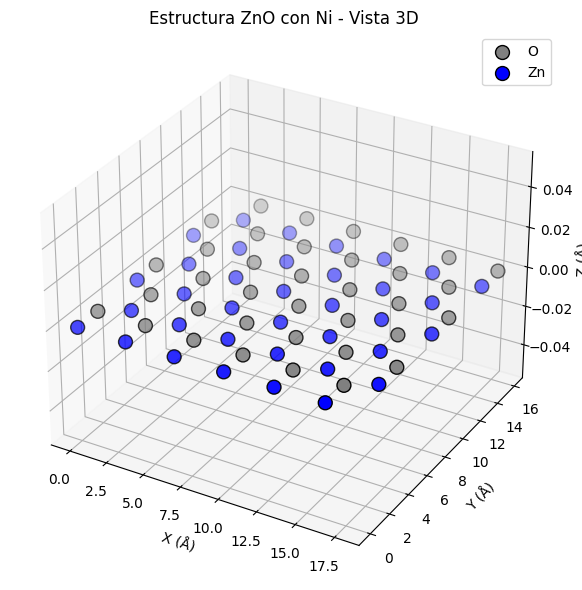

Límites de la estructura calculados:
  - Rango X (con padding): (-2.00, 19.75)
  - Rango Y (con padding): (-2.00, 17.84)
Malla de 2500 posiciones candidatas creada sobre los límites definidos.


Hyperparameter optimization:   0%|          | 0/30 [00:00<?, ?it/s]

Starting position:  0
x,y for try  0 :  [[2.43825686 4.88170408]]


/tmp/ipykernel_18/908564362.py:33: ExperimentalWarning: GPSampler is experimental (supported from v3.6.0). The interface can change in the future.
  study = optuna.create_study(study_name=study_name, direction='minimize', sampler=GPSampler(seed=10))


Starting position:  1
x,y for try  1 :  [[13.533899    9.73937755]]


/tmp/ipykernel_18/908564362.py:33: ExperimentalWarning: GPSampler is experimental (supported from v3.6.0). The interface can change in the future.
  study = optuna.create_study(study_name=study_name, direction='minimize', sampler=GPSampler(seed=10))


Starting position:  2
x,y for try  2 :  [[17.52833017 -0.78558163]]
Starting position:  3
x,y for try  3 :  [[ 7.3203394  15.81146939]]
Starting position:  4
x,y for try  4 :  [[ 9.09564214 -2.        ]]
Starting position:  5
x,y for try  5 :  [[ 3.76973391 12.57302041]]
Starting position:  6
x,y for try  6 :  [[16.19685311 17.8355    ]]
Starting position:  7
x,y for try  7 :  [[12.20242194  4.88170408]]
Starting position:  8
x,y for try  8 :  [[ 1.99443117 -2.        ]]
Starting position:  9
x,y for try  9 :  [[19.30363291  6.90573469]]
Starting position:  10
x,y for try  10 :  [[ 6.87651371 10.5489898 ]]
Starting position:  11
x,y for try  11 :  [[ 1.99443117 17.02588776]]
Starting position:  12
x,y for try  12 :  [[13.97772469 14.1922449 ]]
Starting position:  13
x,y for try  13 :  [[9.98329351 2.85767347]]
Starting position:  14
x,y for try  14 :  [[6.87651371 6.09612245]]
Starting position:  15
x,y for try  15 :  [[-2.         12.16821429]]
Starting position:  16
x,y for try  16 :

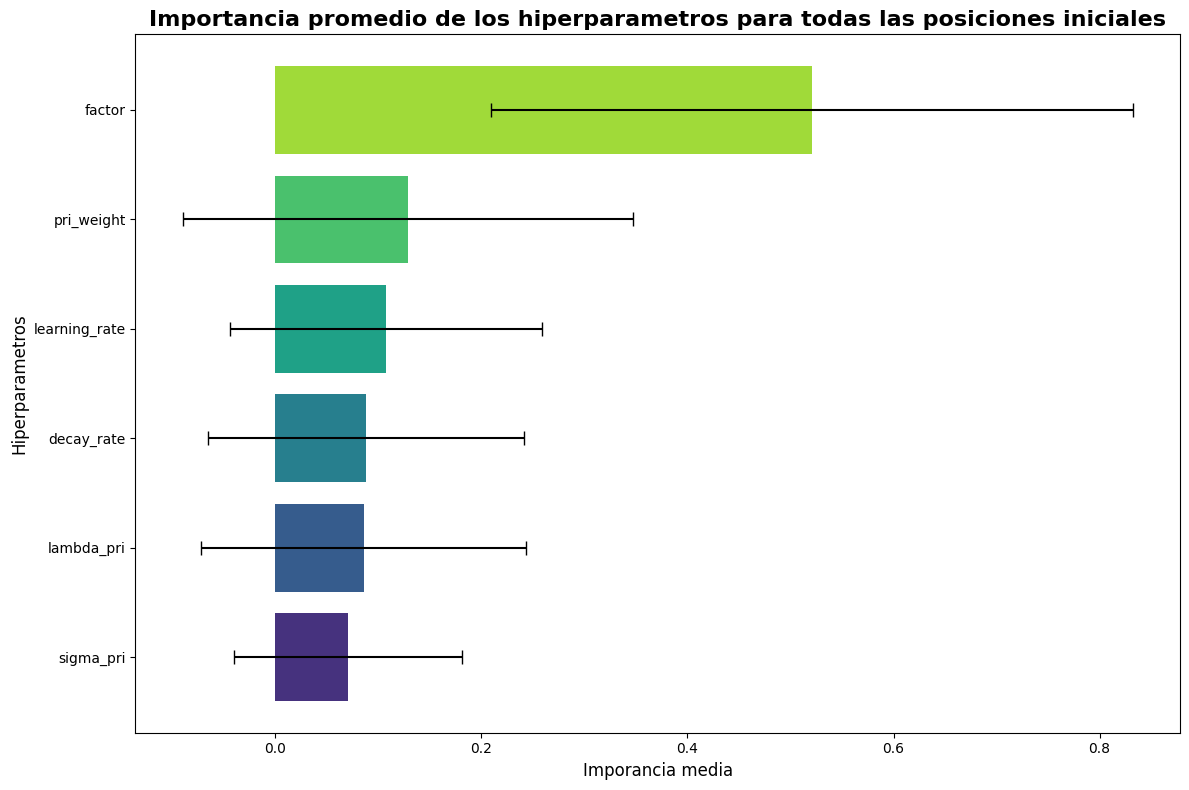


Best Hyperparameters Found:

  Starting position : [[2.43825686 4.88170408]]
  factor: 4.856603216333729
  pri_weight: 0.207519493594015
  lambda_pri: 0.6336482349262754
  sigma_pri: 14.951714273665251
  learning_rate: 0.022154169449531084
  decay_rate: 0.9202316980977763


Training loop progress:   0%|          | 0/300 [00:00<?, ?it/s]

Atomos en la superficie: 72 - Iones a adsorber: 1
Energía total del sistema:0.00000 ev/atom
Energía promedio de adsorcion por ion:0.00000 ev/atom
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(72,)
Desviación estándar de energía por ion: 0.00000 ev/atom
Distancia viajada promedio (vectorial): [ 1.2935803  1.23771   -1.3187294]
Distancia promedio recorrida (magnitud): 2.224 Å


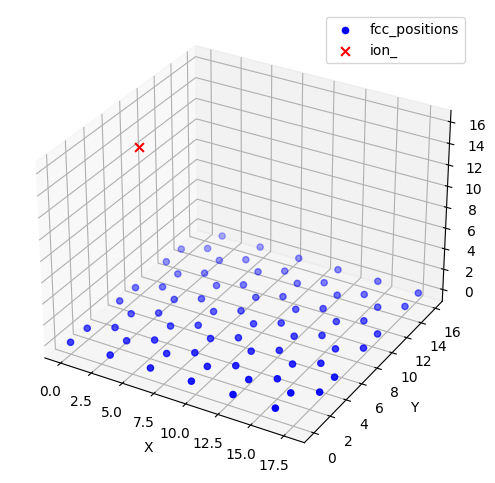

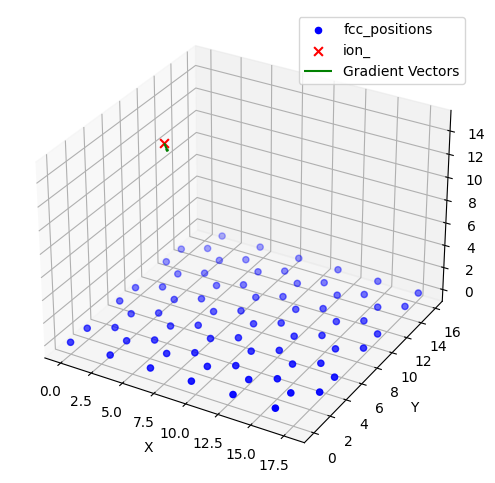

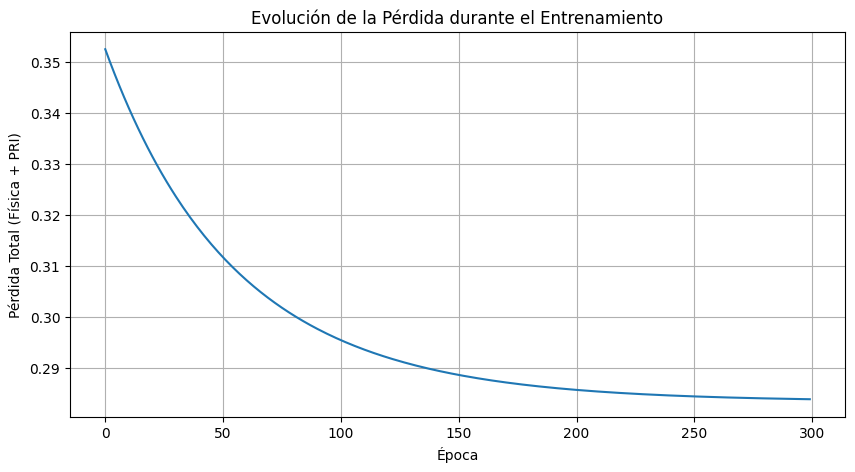

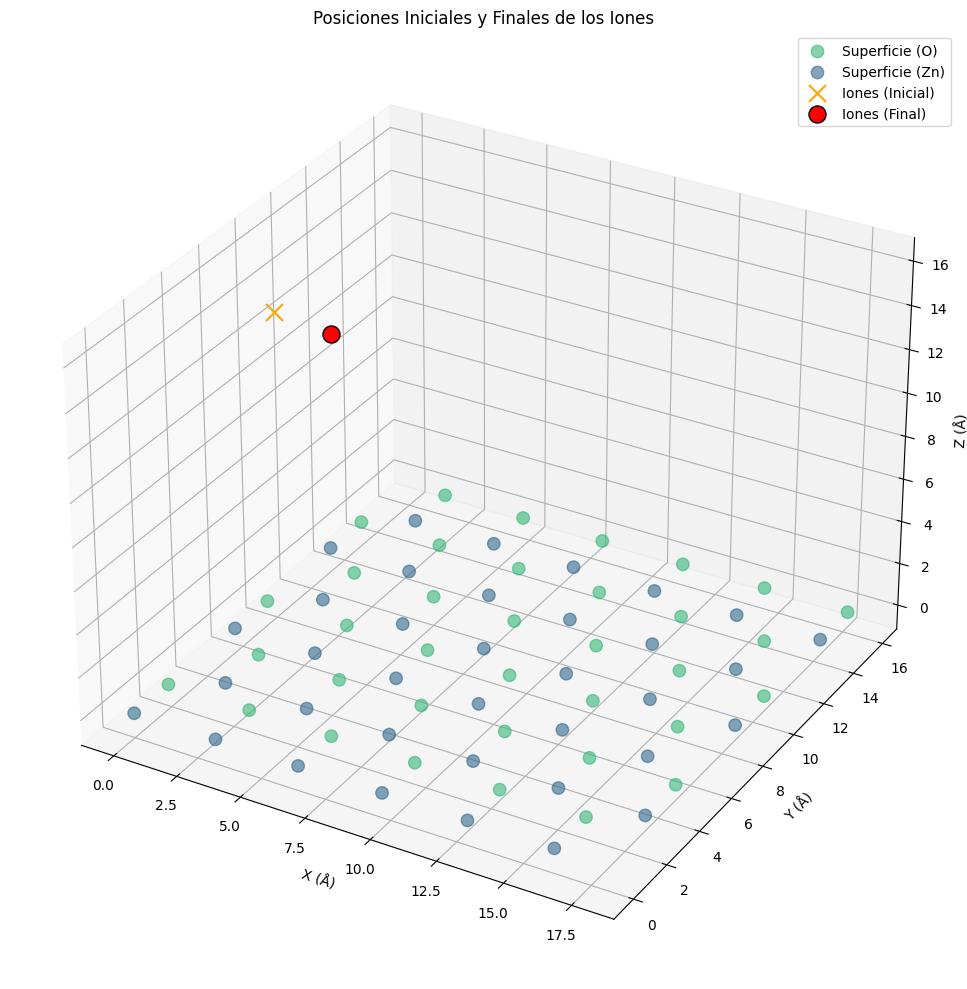

In [26]:
#ejecutamos todo para la muestra 1 tomando el tiempo
start_time = time.time()
sample_name = "ZnO_G"
num_atoms, positions, elements, sample_atoms,sample_elements, geometria = muestra_ZnO_grafeno(rows,a,dist_y,offset_x,cols,dist_x)
puntos_por_eje = 50
k = 30
num_ni = 1
num_trials = 50
Studies,Trials = optimization(positions, geometria, puntos_por_eje, k, num_ni,num_trials, params, param_tensors,random_seed=42)
best_study = optimization_results(Studies, Trials)
epochs = 300
ion_final, ion_final_, starting_pos, loss_history, gradN_3D = training_loop(best_study, epochs,  positions, sample_atoms, sample_elements, 
                                                                            params, param_tensors)
test_and_review(sample_atoms,sample_elements,ion_final,num_atoms, num_ni,starting_pos,loss_history,elements,positions,ion_final_,gradN_3D,
                params, param_tensors)

end_time = time.time()
exc_time = end_time-start_time

In [27]:
print(f"{exc_time:.4f} segundos")

2227.8365 segundos


# Muestra 2. Nanoestructura Al (dummy)

In [28]:
# Parametros de creacion de la muestra

celdas_largo = 10
celdas_alto = 10
celdas_profundidad = 10
a = 7.9 #Parametro de red (A)

In [29]:
# Parametros del potencial L-J

SigmaAl = 3.302 #Radio de vanderwalls del aluminio (A)
EpsilonAl = 7.700e-3 #Fondo del pozo del aluminio (j/mol)
SigmaHg = 2.79 #Radio de vanderwalls del mercurio (A)
EpsilonHg = 10031 #Fondo del pozo mercurio (j/mol)
Sigma_I_L = np.sqrt(SigmaAl*SigmaHg)
Epsilon_I_L = np.sqrt(EpsilonAl*EpsilonHg)
Sigma_I_I = np.sqrt(SigmaHg*SigmaHg)
Epsilon_I_I = np.sqrt(EpsilonHg*EpsilonHg)

#Parametros potencial de coulomb
k_e = 14.3996 #Constante de coulomb en vacio en (eV A/e^2)
#q_Al = 
#q_Hg =

# Radios de corte de intereacción basados en el potencial L-J
r_cutoff_I_L = 2.5*Sigma_I_L #Radio maximo de interacción ion atomo(A)
r_cutoff_I_I = 2.5*Sigma_I_I #Radio maximo de interacción ion ion(A)

In [30]:
# Definimos la creacion de la muestra 
def muestra_Al_dummy(celdas_largo, celdas_alto, celdas_profundidad, a):
    # Dimensiones de la red FCC
    
    
    # --- Posiciones relativas dentro de una celda FCC ---
    relativas_fcc = np.array([
        [0.0, 0.0, 0.0],
        [0.5, 0.5, 0.0],
        [0.5, 0.0, 0.5],
        [0.0, 0.5, 0.5]
    ])
    
    
    # --- Centro y radio de la esfera ---
    centro = np.array([celdas_largo, celdas_alto, celdas_profundidad]) * a / 2  # centrada en medio de la red
    diametro_esfera = min(celdas_largo, celdas_alto, celdas_profundidad) * a
    radio_esfera = diametro_esfera / 2
    
    # --- Posiciones relativas dentro de una celda FCC ---
    relativas_fcc = np.array([
        [0.0, 0.0, 0.0],
        [0.5, 0.5, 0.0],
        [0.5, 0.0, 0.5],
        [0.0, 0.5, 0.5]
    ])
    
    # --- Generar estructura FCC con forma de esfera ---
    posiciones = []
    for i in range(celdas_largo):
        for j in range(celdas_alto):
            for k in range(celdas_profundidad):
                for rel in relativas_fcc:
                    pos = a * (np.array([i, j, k]) + rel)
                    if np.linalg.norm(pos - centro) <= radio_esfera:
                        posiciones.append(pos)
    
    fcc_positions = np.array(posiciones)
    num_atoms = fcc_positions.shape[0]
    print("Número total de átomos FCC (esfera):", num_atoms)
    
    # --- Gráfica 3D ---
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(fcc_positions[:, 0], fcc_positions[:, 1], fcc_positions[:, 2], s=10, color='blue', label="Átomos FCC")
    
    ax.set_xlabel('X (Å)')
    ax.set_ylabel('Y (Å)')
    ax.set_zlabel('Z (Å)')
    ax.set_title('Estructura FCC Esférica')
    ax.legend()
    plt.show()

# Recordar que la funcion que crea la muestra tiene que si o si reetornar minimo las posiciones y el tipo de muestra ("planar","3D")
# Ademas hay que sobrescribir la variable de sample_name para cambiar el nombre de las imagenes de salida
# Las funciones de calculo de energía estan especificas para ZnO, hay que corregir eso para que sea más general
